In [326]:
import os
import sys
import numpy as np
import laspy as lp
import glob
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16
import shutil
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from scipy.interpolate import LinearNDInterpolator
from scipy.spatial import cKDTree
from jakteristics import las_utils, compute_features, FEATURE_NAMES
from tqdm import tqdm
import re
import tempfile

In [327]:
input_ALS_folder = '/home/davidhersh/Dropbox/Uni/ThesisHersh/ALS_data'
output_folder = '/media/davidhersh/T7 Shield/pre-processing/tmp'
dataset_dir = '/media/davidhersh/T7 Shield/Datasets'

In [328]:
point_threshold = 1000

# k-fold
n_splits = 5

# Augmentation values
min_subsample_distance = 0.2
rotations = [-15, 15]
normals_search_radius = 0.5

In [329]:
def copy_folder(input_folder, output_folder=output_folder, point_threshold=point_threshold, plot=True, redo=True):
    """
    Copy single tree ALS files (ending with _g meaning ground classified) for a specific list of trees if they have a minimum point count
    """
    
    if redo:
    
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
            
        # Save figs
        figdir = output_folder.replace('/tmp', '/processing_figures')
        if not os.path.exists(figdir):
            os.makedirs(figdir)
        
        # Only copy certain species
        species_to_copy = [
            "PseMen",
            "FagSyl",
            # "PinSyl",
            "QueRub",
            # "PicAbi",
            "QuePet"
        ]
    
        files = []
        species_counter = Counter()
        
        for root, dirs, filenames in os.walk(input_folder):
            for filename in filenames:
                try:
                    species_name = filename.split('_')[0]
        
                    # Study area BR06 has an issue with ground. Do not copy for further processing
                    # File format: FagSyl_BR02_04_2019-07-05_q2_ALS-on_g.laz
                    study_area = filename.split('_')[1] # BR02
        
                    if filename.endswith('ALS-on_g.laz') and species_name in species_to_copy and study_area != "BR06":
                            las = lp.read(os.path.join(root, filename))
                            number_of_nonground_points = len(las.points[las.classification !=2])
                            if number_of_nonground_points <= point_threshold:
                                species_counter[species_name] += 1
                                files.append(os.path.join(root, filename))  # Store full file paths
                                shutil.copyfile(os.path.join(root, filename), os.path.join(output_folder, filename))
                except: 
                    pass
        print(f'Copying {len(files)} files')
        print(f'Unique species: {species_counter}')
        
        if plot:
            fig, ax = plt.subplots(figsize=(12,8))
            plt.bar(species_counter.keys(), species_counter.values())
            plt.ylabel('Number of trees')
            plt.xlabel('Species')
            plt.title(f"Number of trees with more than {point_threshold} non-ground points")
            plt.savefig(os.path.join(figdir, f'species_count_greaterthan_{point_threshold}_points.png'), bbox_inches='tight')
            plt.show()
        
        return output_folder, species_counter
    
    else:
        print(f'Skipping copying...')


Copying 97 files
Unique species: Counter({'FagSyl': 65, 'QuePet': 25, 'QueRub': 4, 'PseMen': 3})


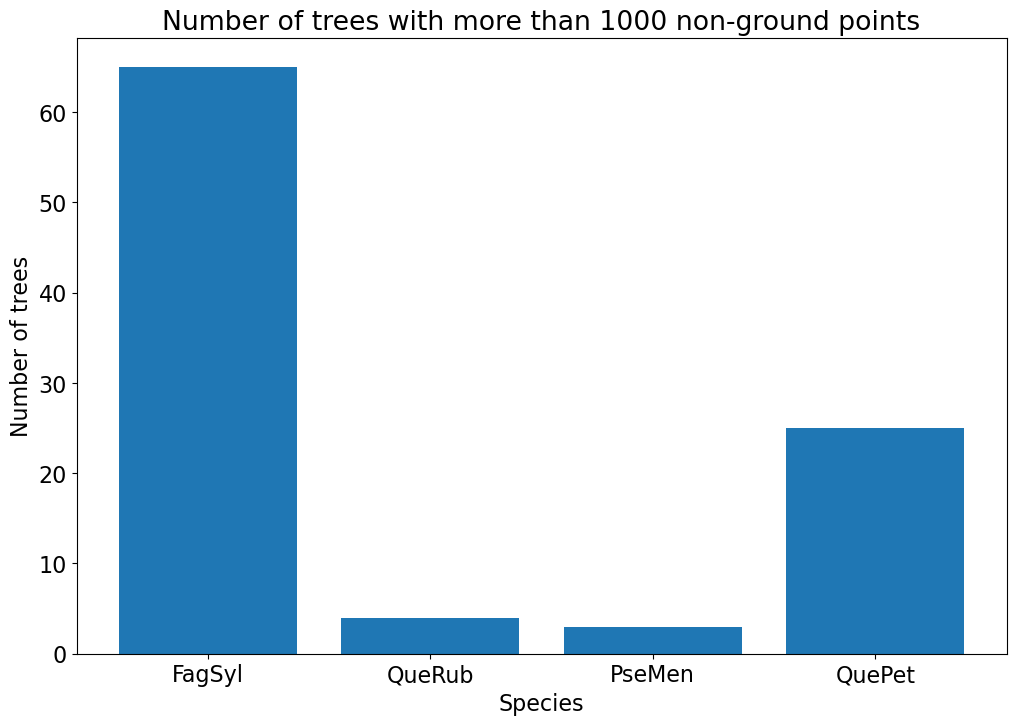

In [330]:
copied_als_folder, species_counter = copy_folder(input_ALS_folder)

In [331]:
def calculate_hag(las_file):
    las = lp.read(las_file)
    x = las.x
    y = las.y
    z = las.z
    
    classification = las.classification
    
    ground_indices = classification == 2
    x_ground = x[ground_indices]
    y_ground = y[ground_indices]
    z_ground = z[ground_indices]
    
    X, Y = np.meshgrid(x_ground, y_ground)
    ground_interpolated = LinearNDInterpolator(list(zip(x_ground, y_ground)), z_ground)
    Z = ground_interpolated(X, Y)
    z_ground_at_points = ground_interpolated(x, y)
    min_ground = np.nanmin(z_ground)
    z_ground_at_points = np.where(np.isnan(z_ground_at_points), min_ground, z_ground_at_points)
    hag = z - z_ground_at_points
    las.z = hag
    las = las[las.classification != 2]
    
    las.write(las_file)

In [332]:
# Can do HAG calculation before split

def convert_hag_to_z(input_folder=copied_als_folder, redo=True):
    
    if redo:
        files = os.listdir(copied_als_folder)
        for file in tqdm(files, desc='Processing files', unit='file'):
            full_path = os.path.join(copied_als_folder, file)
            calculate_hag(full_path)
    else:
        print("Skipping HAG step...")
        
convert_hag_to_z(input_folder=copied_als_folder)

Processing files: 100%|██████████| 97/97 [00:19<00:00,  4.87file/s]


In [342]:
def stratified_k_fold_split(input_folder, output_folder, n_splits=5):
    input_folder = copied_als_folder
    output_folder = input_folder.replace('/tmp', '/kfolders')

    files = []
    labels = []
    
    for file in os.listdir(input_folder):
        class_name = file.split('_')[0] #Fagsyl etc...
        files.append(os.path.join(input_folder, file))
        labels.append(class_name)
    class_counts = Counter(labels)
    print(f'Class counts: {class_counts}')
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=32)
    
    train_folders = []
    test_folders = []
    
    for fold, (train_index, test_index) in enumerate(skf.split(files, labels)):
        fold_train_dir = os.path.join(output_folder, f'fold_{fold+1}_train')
        train_folders.append(fold_train_dir)
        fold_test_dir = os.path.join(output_folder, f'fold_{fold+1}_val')
        test_folders.append(fold_test_dir)
        os.makedirs(fold_train_dir, exist_ok=True)
        os.makedirs(fold_test_dir, exist_ok=True)
        
        for train_idx in train_index:
            shutil.copy(files[train_idx], fold_train_dir)
        for test_idx in test_index:
            shutil.copy(files[test_idx], fold_test_dir)
            
    return train_folders, test_folders
    
train_folders, test_folders = stratified_k_fold_split(copied_als_folder, output_folder, n_splits=n_splits)

Class counts: Counter({'FagSyl': 65, 'QuePet': 25, 'QueRub': 4, 'PseMen': 3})


/home/davidhersh/miniconda3/envs/PointClouds/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


In [343]:
def poisson_subsample(las_file, min_distance=min_subsample_distance):
    las = lp.read(las_file)
    points = np.vstack((las.x, las.y, las.z)).transpose()

    kdtree = cKDTree(points)

    selected = np.zeros(len(points), dtype=bool)
    selected_indices = []
    for i, point in enumerate(points):
        if selected[i]:
            continue

        selected_indices.append(i)
        selected[i] = True

        indices = kdtree.query_ball_point(point, min_distance)
        selected[indices] = True

    header = lp.LasHeader(point_format=las.header.point_format, version=las.header.version)
    header.offsets = las.header.offsets
    header.scales = las.header.scales

    subsampled_las = lp.LasData(header)
    subsampled_las.points = las.points[selected_indices]

    subsampled_las.write(las_file)

In [344]:
def normalize_xy(las_file):
        las = lp.read(las_file)
        original_offset_x = las.header.offsets[0]
        original_offset_y = las.header.offsets[1]
        scale_x = las.header.scales[0]
        scale_y = las.header.scales[1]

        x = las.x
        y = las.y

        mean_x = np.mean(x)
        mean_y = np.mean(y)
        
        # Normalize coordinates
        normalized_x = x - mean_x
        normalized_y = y - mean_y

        new_header = lp.LasHeader(point_format=las.header.point_format, version=las.header.version)
        new_header.scales = las.header.scales

        new_header.offsets = [
            original_offset_x - mean_x,
            original_offset_y - mean_y,
            las.header.offsets[2]  # Same z
        ]

        new_las = lp.LasData(new_header)
        new_las.x = normalized_x
        new_las.y = normalized_y
        new_las.z = las.z

        for dim_name in las.point_format.dimension_names:
            if dim_name not in ["X", "Y", "Z"]:
                setattr(new_las, dim_name, getattr(las, dim_name))

        new_las.write(las_file)

In [345]:
def rotate_z(pointcloud, degrees):
    theta = np.deg2rad(degrees)

    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])

    return np.dot(pointcloud, rotation_matrix.T)


def rotate_las(las_file, rotations):
        las = lp.read(las_file)

        point_data = np.vstack((las.x, las.y, las.z)).T

        for i, rotation in enumerate(rotations):

            rotated_points = rotate_z(point_data, rotation)

            header = lp.LasHeader(point_format=las.header.point_format, version=las.header.version)
            header.offsets = las.header.offsets
            header.scales = las.header.scales
            # header.crs = lp.crs.CRS.from_epsg(25832)

            rotated_las = lp.LasData(header)
            rotated_las.x = rotated_points[:, 0]
            rotated_las.y = rotated_points[:, 1]
            rotated_las.z = rotated_points[:, 2]

            for dim_name in las.point_format.dimension_names:
                if dim_name not in ["X", "Y", "Z"]:
                    setattr(rotated_las, dim_name, getattr(las, dim_name))

            unique_filename = las_file.replace('.laz', f'_rot_{rotation}.laz')
            output_filename = os.path.join(output_folder, unique_filename)

            os.makedirs(output_folder, exist_ok=True)
            rotated_las.write(output_filename)

In [346]:
def calculate_normals(las_file):
    las = lp.read(las_file)
    FEATURE_NAMES = ['nx', 'ny', 'nz']
    
    # Remove nx, ny, nz if existing
    for feature_name in FEATURE_NAMES:
        if feature_name in las.point_format.dimension_names:
            las.point_format.remove_extra_dimension(feature_name)
    
    xyz = las_utils.read_las_xyz(las_file)
    
    features = compute_features(xyz, search_radius=normals_search_radius, feature_names=FEATURE_NAMES)
    
    output_file = las_file.replace('.laz', '_normals.laz')
    
    if not os.path.exists(output_file):
        las_utils.write_with_extra_dims(las_file, output_file, features, FEATURE_NAMES)
        os.remove(las_file)

In [347]:
# Augment each folder

def augmentation(train_folders=train_folders, test_folders=test_folders, 
                 redo_xy_normalization=True,
                 redo_subsample=True,
                 redo_rotation=True):

    all_folders = train_folders + test_folders
    for folder in all_folders:
        for las_file in os.listdir(folder):
            
            # Normalize x,y by means
            if redo_xy_normalization:
                normalize_xy(las_file=os.path.join(folder, las_file))
            else:
                pass
            
            # Downsample using minimum distance
            if redo_subsample:
                poisson_subsample(las_file=os.path.join(folder, las_file),
                                  min_distance=min_subsample_distance)
            else:
                pass
            
            # Rotate on z-axis
            if redo_rotation:
                rotate_las(os.path.join(folder, las_file), rotations=rotations)
            else:
                pass
            
    # Need to relist the folders with the new rotated files            
    for folder in all_folders:
        for las_file in os.listdir(folder):
            
            # Calculate normals
            calculate_normals(os.path.join(folder, las_file))
    
augmentation()

In [349]:
# Need to deal with nan normal values
def convert_to_txt(train_folders=train_folders, test_folders=test_folders):
    all_folders = train_folders + test_folders

    for folder in all_folders:
        for las_file in os.listdir(folder):
            if not las_file.endswith(('laz', 'las')):
                continue
            las = lp.read(os.path.join(folder, las_file))
            output_file = las_file.replace('.laz', '.txt')
            
            with open(os.path.join(folder, output_file), 'w') as f:
                for x, y, z, nx, ny, nz in zip(las.x, las.y, las.z, las.nx, las.ny, las.nz):
                    f.write(f'{x:.6f}, {y:.6f}, {z:.6f}, {nx}, {ny}, {nz}\n')
            os.remove(os.path.join(folder, las_file))
convert_to_txt()


In [360]:
# Convert to KPConv repository dataset format

def copy_to_datasets(train_folders=train_folders, test_folders=test_folders, n_splits=n_splits):
    all_folders = train_folders + test_folders
    base_folder = train_folders[0]
    base_folder_test = test_folders[0]
    print(f'base test folder: {base_folder_test}')
    print(base_folder)
    
    # Get the folders of the species
    species_set = set()
    for folder in all_folders:
        for las_file in os.listdir(folder):
            species = las_file.split('_')[0]
            species_set.add(species)
    print(f'species_set: {species_set}')
    
    for i in range(1, n_splits+1):
        
        # Make a folder for each dataset
        datadir = os.path.join(dataset_dir, f'data_{i}')
        os.makedirs(datadir, exist_ok=True)
        
        # Make a subfolder for each species
        species_dirs = {species: os.path.join(datadir, species) for species in species_set}
        for species_dir in species_dirs.values():
            os.makedirs(species_dir, exist_ok=True)
        
        # Create filelist.txt, train.txt and test.txt files in the folder
        filelist_txt_file = os.path.join(datadir, 'filelist.txt')
        train_txt_file = os.path.join(datadir, 'train.txt')
        test_txt_file = os.path.join(datadir, 'test.txt')
        
        # Process training files
        train_folder = re.sub(r"fold_\d+_train", f'fold_{i}_train', base_folder)
        with open (train_txt_file, 'w') as f:
            for file in os.listdir(train_folder):
                if file.endswith('.txt'):
                    f.write(file + '\n')
                else:
                    pass
            # print(f'Processed: {i} train files')
        
        for file in os.listdir(train_folder):
            species = file.split('_')[0]
            if file.endswith('.txt'):
                shutil.copy(os.path.join(train_folder, file), species_dirs[species])
            else:
                pass
                
        # Process test files
        test_folder = re.sub(r"fold_\d+_val", f'fold_{i}_val', base_folder_test)
        print(f'Test folder: {test_folder}')
        test_files = [file for file in os.listdir(test_folder) if file.endswith('.txt')]
        print(len(test_files))
        with open(test_txt_file, 'w') as f:
            for file in os.listdir(test_folder):
                if file.endswith('.txt'):
                    f.write(file + '\n')
                else:
                    pass
                
        for file in os.listdir(test_folder):
            species = file.split('_')[0]
            if file.endswith('.txt'):
                shutil.copy(os.path.join(test_folder, file), species_dirs[species])
            else:
                pass
                
        
        
copy_to_datasets()
# Loop over each dataset and run trainNeuesPalaisTrees.py
# Need to pass config parameters here and update class_w

base test folder: /media/davidhersh/T7 Shield/pre-processing/kfolders/fold_1_val
/media/davidhersh/T7 Shield/pre-processing/kfolders/fold_1_train
species_set: {'QueRub', 'PseMen', 'QuePet', 'FagSyl'}
Test folder: /media/davidhersh/T7 Shield/pre-processing/kfolders/fold_1_val
60
Test folder: /media/davidhersh/T7 Shield/pre-processing/kfolders/fold_2_val
60
Test folder: /media/davidhersh/T7 Shield/pre-processing/kfolders/fold_3_val
57
Test folder: /media/davidhersh/T7 Shield/pre-processing/kfolders/fold_4_val
57
Test folder: /media/davidhersh/T7 Shield/pre-processing/kfolders/fold_5_val
57
